<a href="https://colab.research.google.com/github/yuvalofek/FrequentistML/blob/master/FreqML2_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Logistic Regression Assignment**

1. Implement logistic regression with stochastic gradient descent as the optimization algorithm, with and without the L2 regularization penalty. 

2. Divide your data into roughly 80% train, 10% validation, 10% test as in the previous assignment and use the validation dataset to tune any parameters.

3. Replicate the analysis of the South African heart disease dataset from the Elements of Statistical Learning textbook, in particular Table 4.2, and 4.3, and figure 4.12. Additionally, report the % correct for all 3 models (unregularized, stepwise, and L2 regularized) in a table.

4. Repeat this analysis for a binary classification dataset of your choice from UCI or another reporistory.


**Stretch goal #1 (3 points):** Implement the L1 penalty as well, and produce a Lasso plot like figure 4.13. Include your results in the % correct table. Use the validation dataset to select the optimal lambda and determine the most important features. Do those features agree with the stepwise feature selection?

There are lots of ways to implement the L1 penatly, one possible way is the naive one detailed in this paper:  https://www.aclweb.org/anthology/P09-1054.pdf

**Stretch goal #2 (3 points):** Extend your unregularized logistic regression to mutlinomial regression(i.e. more than binary classification). It is a pretty straightforward extension, but its not covered in elements of stats. You can google for derivations if you want, but mainly all you really need is to find the gradient of the loss function in the multinomial case. This is covered in section 4.3.4 of another classic ML text by Bishop(bootleg pdf here: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf). The equation for the gradient is eqn 4.109. Test your approach on a simple M-ary classification dataset like the Iris dataset from UCI.

##Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split  #for spliting data
import sklearn.preprocessing as prep    #preprocessing
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Heart Disease Dataset

In [ ]:
#import prostate.data
!wget -O hdisease.data https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data

#looking at prostate.data to verify formatting
!cat hdisease.data | head -5

--2020-09-17 19:12:41--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25106 (25K)
Saving to: ‘hdisease.data’

hdisease.data       100%[===================>]  24.52K   157KB/s    in 0.2s    

2020-09-17 19:12:42 (157 KB/s) - ‘hdisease.data’ saved [25106/25106]

row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
1,160,12.00, 5.73,23.11,Present,49,25.30, 97.20,52,1
2,144, 0.01, 4.41,28.61,Absent,55,28.87,  2.06,63,1
3,118, 0.08, 3.48,32.28,Present,52,29.14,  3.81,46,0
4,170, 7.50, 6.41,38.03,Present,51,31.99, 24.26,58,1


In [ ]:
#reading the data into a numpy array of floats
df_hdisease = pd.read_csv('hdisease.data',
                 index_col = 0,
                 )
#text to numerical
df_hdisease.insert(0, '(intercept)', 1)
df_hdisease['famhist'] = (df_hdisease['famhist'] == 'Present')*1  
df_hdisease.pop('adiposity')

heart_data = df_hdisease.to_numpy().astype('float')
df_hdisease.head()

,(intercept),sbp,tobacco,ldl,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,1,160,12.00,5.73,1,49,25.30,97.20,52,1
2,1,144,0.01,4.41,0,55,28.87,2.06,63,1
3,1,118,0.08,3.48,1,52,29.14,3.81,46,0
4,1,170,7.50,6.41,1,51,31.99,24.26,58,1
5,1,134,13.60,3.50,1,60,25.99,57.34,49,1


In [ ]:
def train_val_test_split(X,y, test_size, val_size, random_state = None):
  '''Extended train_test_split to also provide a validation set'''

  #We want to split the data in 3, but the train_test_split only splits in 2. 
  #This means we need to split once to get a testing set and an intermediate set 
  #which we split again to get the validation and training sets. because 
  #train_test_split takes a percentage to determine the split, we first determine 
  #the relative percentage of the intermediate set needed to generate the 
  #necessary number of samples in the validation set:
  rel_val_percent = np.round((val_size)/(1-test_size), 2)

  #splitting the data
  X_inter, X_test, y_inter, y_test = train_test_split(X,
                                                      y,
                                                      test_size = test_size,
                                                      random_state = random_state
                                                      )
  X_train, X_val, y_train, y_val = train_test_split(X_inter,
                                                      y_inter,
                                                      test_size = rel_val_percent,
                                                      random_state = random_state
                                                      )
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
#data splitting conditions
PERCENT_VAL = 0.10
PERCENT_TEST = 0.10
random_state = 25  #for reproducibility
split_data = train_val_test_split(heart_data[:,:-1],
                                  heart_data[:,-1],
                                  PERCENT_TEST,
                                  PERCENT_VAL,
                                  random_state)
#unpacking
X_train, X_val, X_test, y_train, y_val, y_test = split_data

print('Input length:', len(heart_data))
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_val))
print('Number of testing samples:', len(X_test))

Input length: 462
Number of training samples: 369
Number of validation samples: 46
Number of testing samples: 47


In [ ]:
#normalize data:
transformer = prep.MaxAbsScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

trans_y = prep.MaxAbsScaler().fit(y_train.reshape(-1, 1))
y_train = trans_y.transform(y_train.reshape(-1, 1)).reshape(-1)
y_val = trans_y.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test = trans_y.transform(y_test.reshape(-1, 1)).reshape(-1)

##Data Visualization


###Figure 4.12


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


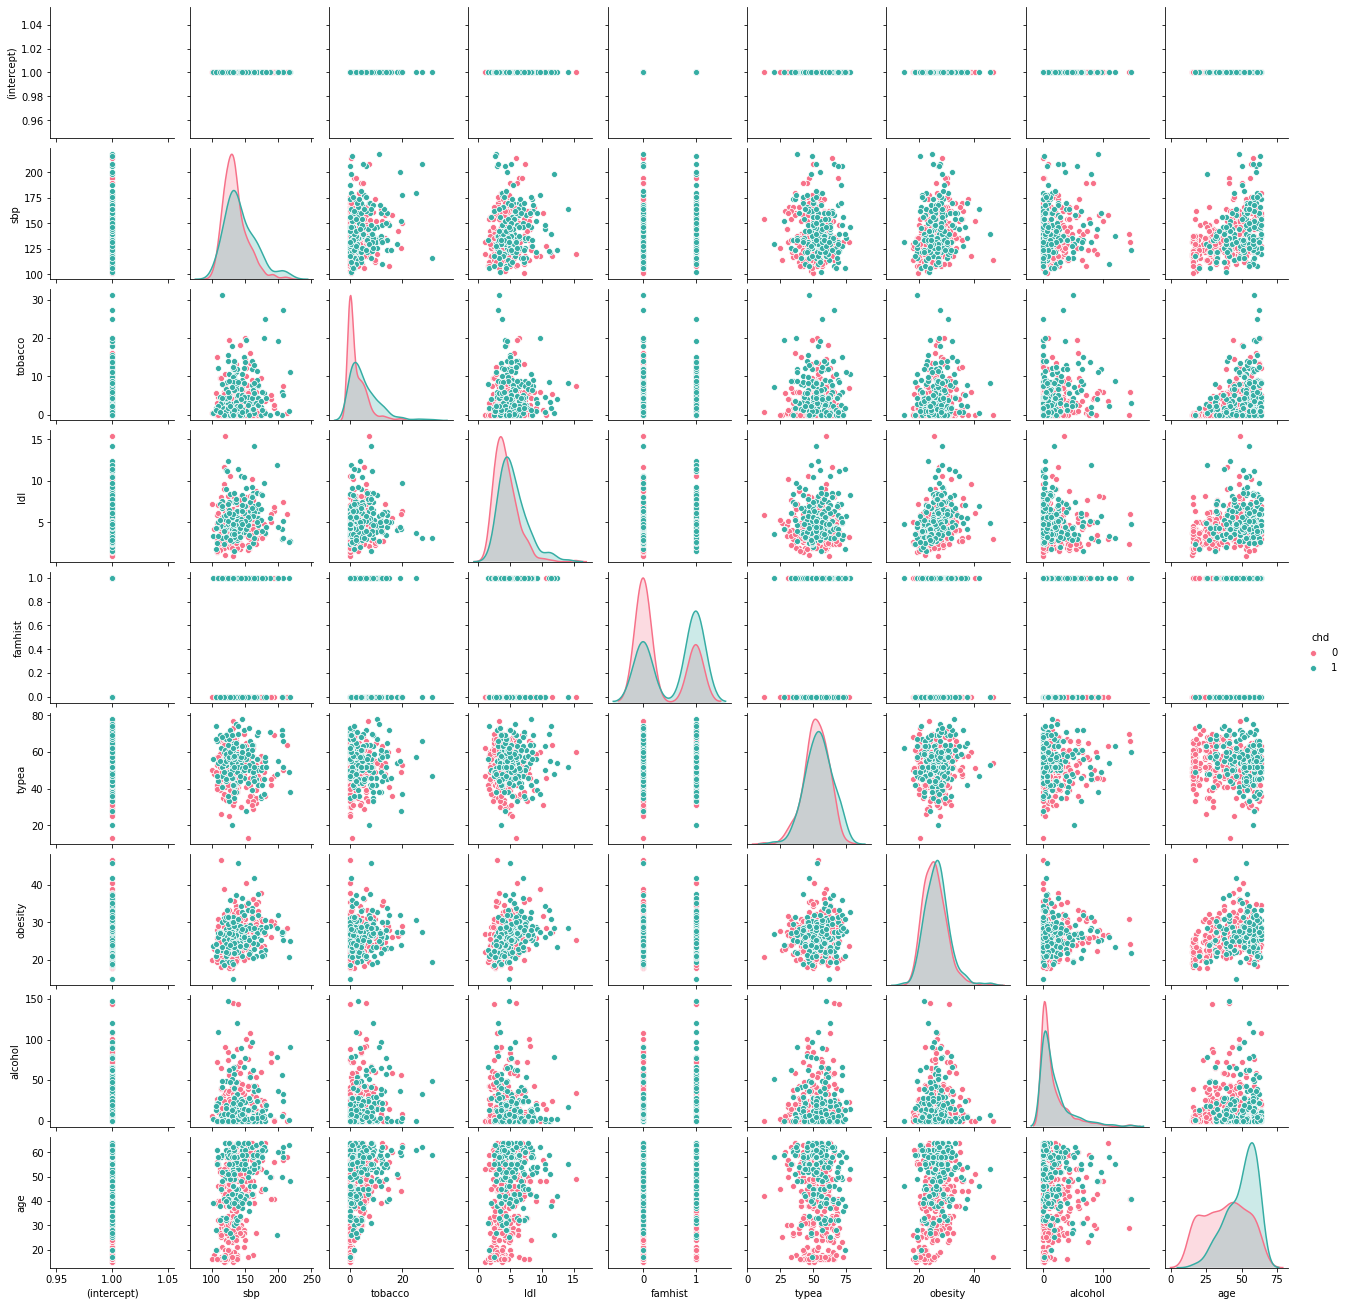

In [ ]:
#sns.pairplot(df_hdisease, hue = 'chd',palette="husl", height = 2)

##Logistic Model

In [ ]:
class LogisticModel:
  def __init__(self, feature_num, lr = 0.001):
    self.lr = lr
    self.weights = np.random.randn(feature_num,1)/np.sqrt(feature_num)

  def predict(self,x):
    ''' Using stored coefficients, predict output based on data x'''
    def sigmoid(z):
      return 1/(1+np.exp(-z))
    #add the 1 to beta to get intercept
    X  = x.T
    #WX+B and sigmoid
    return sigmoid(self.weights.T@X)
    
  def loss(self, y, y_hat, reg = None, lambd = None):
    loss = -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))
    if reg == 'L2':
      loss += lambd*np.sum(self.weights**2)
    elif reg == 'L1':
      loss += lambd*np.sum(np.abs(self.weights))
    return loss
    
  def update(self,x, y,y_hat, reg, lambd):
    X = x.T
    Y = y.reshape(1,-1)
    if reg is None:
      self.weights += self.lr*(X)@((Y-y_hat).T)
    elif reg == 'L2':
      ones = np.ones(self.weights.shape)
      ones[0] = 0
      self.weights += self.lr*(X)@((Y-y_hat).T)+ lambd*ones
    else:
      '''L1 Update'''

  def step(self, x,y, reg = None, lambd = None):
    y_hat = self.predict(x)
    lss = self.loss(y, y_hat, reg, lambd)
    self.update(x,y, y_hat, reg, lambd)
    return lss

  def fit(self,x, y, num_iter,
          x_val= None, y_val = None,
          reg= None, lambd = 0.0001, verbose = True):
    val_str = ''
    cache = []
    val_loss = []
    for i in range(num_iter):
      for j in range(x.shape[0]):
        x_j = x[j,:].reshape(1,-1)  #1xp
        y_j = y[j].reshape(1,-1)  #1x1

        self.step(x_j, y_j, reg, lambd)
      
      #Training printout
      if verbose:
        p_train = int((i+1)/num_iter*100)
        y_hat = self.predict(x)
        err =  percent_correct(y, y_hat)
        lss = self.loss(y, y_hat, reg , lambd)
        cache.append(lss)
        tr_per = f'\r Training completed: {p_train}% |'
        tr_l = f'Training Loss: {np.around(lss, 5)} |'
        tr_err = f'Training Percent Correct: {err}'
        print_str = tr_per + tr_l  +  tr_err
        
        if x_val is not None:
          yh_val = self.predict(x_val)
          val_loss.append(self.loss(y_val, yh_val, reg , lambd))
          err_v =  percent_correct(y_val, yh_val)
          val_l = f'|Validation Loss: {np.around(val_loss[-1], 5)} |'
          val_err = f'Validation Percent Correct: {err_v}'
          val_str = val_l+ val_err
        print(print_str+val_str, end = '')
    print('')
    return cache, val_loss

def percent_correct(y, y_hat):
  '''
  Percentage of y that y_hat correctly predicts
  '''
  N_examples = y_hat.shape[1]
  N_wrong = np.sum(np.abs((np.round(y_hat) - y)))
  return np.round((N_examples - N_wrong)*100/N_examples, 1)

In [ ]:
num_iter = 3000
logmodel = LogisticModel(X_train.shape[1])
cache, val_loss = logmodel.fit(X_train, y_train, num_iter, X_val, y_val);

 Training completed: 100% |Training Loss: 0.5158 |Training Percent Correct: 72.9|Validation Loss: 0.52813 |Validation Percent Correct: 78.3


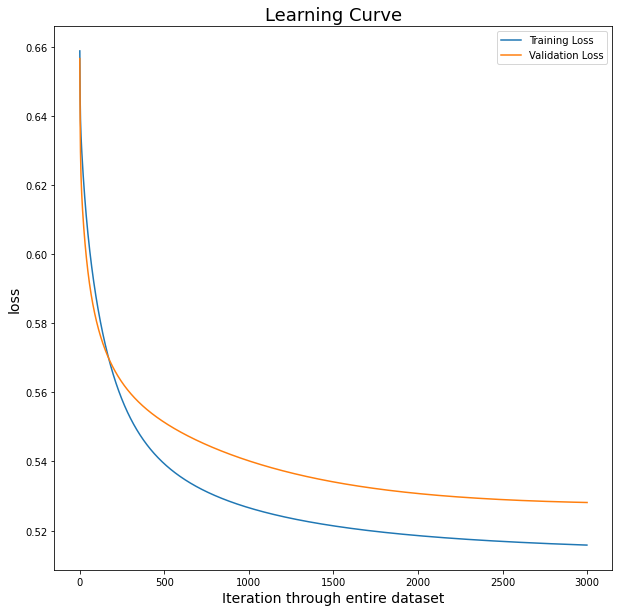

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(cache)
if val_loss:    #only plot if we have this list
  plt.plot(np.linspace(0,num_iter, len(val_loss)),val_loss)

plt.xlabel('Iteration through entire dataset', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.title('Learning Curve', fontsize = 18)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

###Table 4.2

In [ ]:
def z_scorer(X, y, y_hat, weights):
  '''Returns standard error and z-score'''
  #extract metrics from x
  N = len(X_train)
  p = X.shape[1]

  #Using 3.8b to get the stdv
  sigma =  np.sqrt(np.sum((y -y_hat)**2)/(N-p-1))
  
  #implement equation 3.12 to get the z score
  sqrt_v = np.sqrt(np.diagonal(np.linalg.inv(np.matmul(X.T, X))))
  standard_error = sigma*sqrt_v
  z_score = weights/standard_error.reshape(-1,1)

  return standard_error,z_score

def format_lin_summary_table(term, beta, s_e, z_scr, round_decimal = 2):
  '''Function to format the data into a summary table'''
  summary_mat = []
  #generate a list of lists, where the inner lists are rows
  for coeff_num in range(len(term)):
    row = list([term[coeff_num],
              np.round(beta[coeff_num][0], round_decimal),
              np.round(s_e[coeff_num], round_decimal),
              np.round(z_scr[coeff_num][0], round_decimal)])
    summary_mat.append(row)

  return summary_mat

In [ ]:
#coefficient analysis table
y_hat = logmodel.predict(X_train)
weights = np.array(logmodel.weights)
standard_error, Z_score = z_scorer(X_train, y_train,y_hat, weights )

term = list(df_hdisease.columns.values[:-1])
summary_lst = format_lin_summary_table(term,weights , standard_error, Z_score)

summary_header = ['Term', 'Coefficeint', 'Std. Error', 'Z Score']
summary = tabulate(summary_lst, headers = summary_header, tablefmt='pretty')
print('      Table 2: Logistic model fit to the data.')
print(summary)

      Table 2: Logistic model fit to the data.
+-------------+-------------+------------+---------+
|    Term     | Coefficeint | Std. Error | Z Score |
+-------------+-------------+------------+---------+
| (intercept) |    -4.8     |    0.22    | -21.72  |
|     sbp     |    0.54     |    0.25    |  2.12   |
|   tobacco   |     2.5     |    0.17    |  14.63  |
|     ldl     |    2.41     |    0.18    |  13.31  |
|   famhist   |    0.95     |    0.05    |  20.49  |
|    typea    |     1.8     |    0.19    |  9.59   |
|   obesity   |    -1.84    |    0.27    |  -6.9   |
|   alcohol   |    0.14     |    0.14    |  1.06   |
|     age     |    3.05     |    0.12    |  25.29  |
+-------------+-------------+------------+---------+


##Reducing the feature space

In [ ]:
#We drop physical data here 
drop = [7,6,1]  #alcohol, obesity, sbp

X_train_red = X_train.copy()
X_val_red = X_val.copy()
X_test_red = X_test.copy()

#dropping columns
for i in range(len(drop)):
  X_train_red = np.delete(X_train_red, drop[i],1) 
  X_val_red = np.delete(X_val_red, drop[i],1) 
  X_test_red = np.delete(X_test_red, drop[i],1) 


In [ ]:
num_iter = 3000
logmodel = LogisticModel(X_train_red.shape[1])
cache, val_loss = logmodel.fit(X_train_red, y_train, num_iter, X_val_red, y_val);

 Training completed: 100% |Training Loss: 0.51906 |Training Percent Correct: 71.5|Validation Loss: 0.54545 |Validation Percent Correct: 76.1


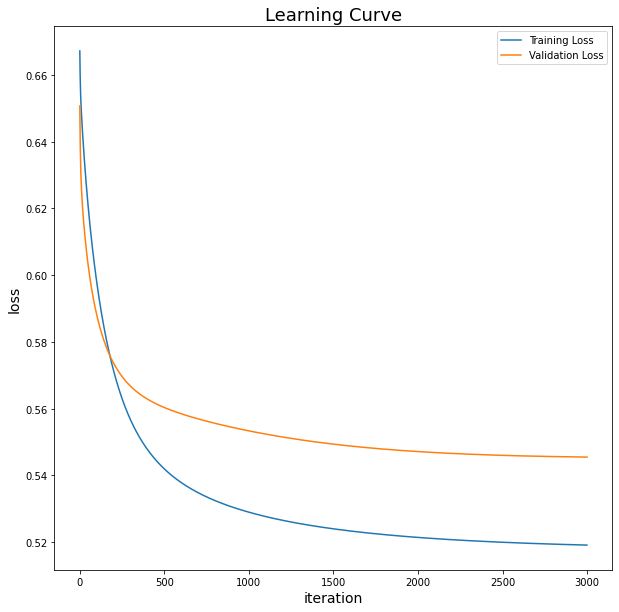

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(cache)
if val_loss:    #only plot if we have this list
  plt.plot(np.linspace(0,num_iter, len(val_loss)),val_loss)

plt.xlabel('iteration', fontsize = 14)
plt.ylabel('loss', fontsize = 14)
plt.title('Learning Curve', fontsize = 18)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

### Table 4.3

In [ ]:
#coefficient analysis table
y_hat = logmodel.predict(X_train_red)
weights = np.array(logmodel.weights)
standard_error, Z_score = z_scorer(X_train_red, y_train,y_hat, weights )

term = list(['(intercept)','tobacco',
             'ldl','famhist',
             'typea','age'])
summary_lst = format_lin_summary_table(term,weights , standard_error, Z_score)

summary_header = ['Term', 'Coefficeint', 'Std. Error', 'Z Score']
summary = tabulate(summary_lst, headers = summary_header, tablefmt='pretty')
print('      Table 2: Logistic model fit to the data.')
print(summary)

      Table 2: Logistic model fit to the data.
+-------------+-------------+------------+---------+
|    Term     | Coefficeint | Std. Error | Z Score |
+-------------+-------------+------------+---------+
| (intercept) |    -5.24    |    0.15    | -34.81  |
|   tobacco   |    2.55     |    0.17    |  15.15  |
|     ldl     |     2.1     |    0.17    |  12.17  |
|   famhist   |    0.94     |    0.05    |  20.38  |
|    typea    |    1.65     |    0.19    |  8.89   |
|     age     |     3.0     |    0.11    |  26.48  |
+-------------+-------------+------------+---------+


##Comparing Regularization Models

In [ ]:
#parameters
num_iter = 100
N = 5   #number of lambdas to check 
lambd_vals = np.logspace(-6,-4, N)

logmodel = LogisticModel(X_train.shape[1])

#no regularizaiton -> no need to check lambda
logmodel.fit(X_train, y_train, num_iter, X_val, y_val,)
yh = logmodel.predict(X_test)
err = percent_correct(y_test, yh)

val_ = np.zeros(shape=(N,1))
for i, lam in enumerate(lambd_vals):
  logmodel.fit(X_train, y_train, num_iter, X_val,
               y_val, reg = 'L2', lambd = lam)
  yh_L2 = logmodel.predict(X_val)
  val_[i] = percent_correct(y_val, yh_L2)

best_lam_L2 = lambd_vals[np.argmax(val_)]
logmodel.fit(X_train, y_train, num_iter, X_val, y_val,
             reg = 'L2', lambd = best_lam_L2)
yh_L2 = logmodel.predict(X_val)
err_L2 = percent_correct(y_val, yh_L2)


'''
  logmodel.fit(X_train, y_train, num_iter,reg = 'L1')
  yh_L1 = logmodel.predict(X_test)
  err_L1 = percent_correct(y_test, yh_L1)
'''

 Training completed: 100% |Training Loss: 0.59284 |Training Percent Correct: 71.3|Validation Loss: 0.57643 |Validation Percent Correct: 73.9





 Training completed: 100% |Training Loss: 0.58749 |Training Percent Correct: 71.0|Validation Loss: 0.67551 |Validation Percent Correct: 73.9


"\n  logmodel.fit(X_train, y_train, num_iter,reg = 'L1')\n  yh_L1 = logmodel.predict(X_test)\n  err_L1 = percent_correct(y_test, yh_L1)\n"

In [ ]:
best_lam_L2

1e-06

In [ ]:
Models = list(['Unregularized', 'L1 Regularization', 'L2 Regularization'])
errs = list([[err, err_L1, err_L2]])

table = tabulate(errs, headers=Models, tablefmt='pretty')
print('\t Table #: % Correct for all 3 Models')
print(table)

	 Table #: % Correct for all 3 Models
+---------------+-------------------+-------------------+
| Unregularized | L1 Regularization | L2 Regularization |
+---------------+-------------------+-------------------+
|     80.9      |       78.7        |       66.0        |
+---------------+-------------------+-------------------+
